# ⚽ Analyse Complète des Statistiques d'Équipe - Ligue 1

## Objectif
Ce notebook génère un **rapport complet et interactif** d'un match de Ligue 1 avec :
- 📊 Statistiques avancées (possession, tirs, passes, duels, etc.)
- 📈 Visualisations interactives avec Plotly
- 📄 Export HTML du rapport final

---

In [ ]:
# Imports
import pandas as pd
import json
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from datetime import datetime

print("✅ Bibliothèques chargées")

## 📂 Section 1 : Chargement des données

### 🎓 Leçon : Fonction réutilisable
En tant que data analyst, vous devez créer des fonctions réutilisables pour éviter de répéter le code.

In [15]:
def charger_match(match_id):
    """
    Charge les données d'un match depuis le fichier JSON.
    
    Args:
        match_id (str): ID du match (ex: '3900493')
    
    Returns:
        pd.DataFrame: DataFrame normalisé des événements du match
    """
    file_path = f'../data/ligue1/{match_id}.json'
    
    print(f"📂 Chargement du match {match_id}...")
    
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    df = pd.json_normalize(data)
    
    print(f"✅ {len(df)} événements chargés")
    print(f"🏟️ Équipes : {df['team.name'].unique()}")
    
    return df

# Charger un match
MATCH_ID = '3900493'  # Lyon vs Troyes
df = charger_match(MATCH_ID)

📂 Chargement du match 3900493...
✅ 3848 événements chargés
🏟️ Équipes : ['Troyes' 'Lyon']


## 📊 Section 2 : Calcul des statistiques complètes

### 🎓 Leçon : Métriques importantes en analyse football

Un rapport professionnel inclut :
- **Possession** : temps de contrôle du ballon
- **Passes** : total, réussies, taux de réussite
- **Tirs** : total, cadrés, buts, xG (expected goals)
- **Actions défensives** : tacles, interceptions, dégagements
- **Duels** : aériens et au sol
- **Discipline** : fautes, cartons
- **Phases arrêtées** : corners, coups francs

In [16]:
def calculer_statistiques_equipe(df, team_name):
    """
    Calcule toutes les statistiques pour une équipe.
    
    Args:
        df: DataFrame du match
        team_name: Nom de l'équipe
    
    Returns:
        dict: Dictionnaire avec toutes les statistiques
    """
    df_team = df[df['team.name'] == team_name]
    
    stats = {'Équipe': team_name}
    
    # ===== POSSESSION =====
    stats['Possession (min)'] = round(df_team['duration'].sum() / 60, 1)
    stats['Possession (%)'] = round(
        df_team['duration'].sum() / df['duration'].sum() * 100, 1
    )
    
    # ===== PASSES =====
    passes = df_team[df_team['type.name'] == 'Pass']
    passes_reussies = passes[passes['pass.outcome.name'].isna()]
    
    stats['Passes totales'] = len(passes)
    stats['Passes réussies'] = len(passes_reussies)
    stats['Taux de passes (%)'] = round(
        len(passes_reussies) / len(passes) * 100, 1
    ) if len(passes) > 0 else 0
    
    # Passes par zone
    stats['Passes longues'] = len(passes[passes['pass.length'] >= 30])
    stats['Passes courtes'] = len(passes[passes['pass.length'] < 30])
    
    # ===== TIRS =====
    shots = df_team[df_team['type.name'] == 'Shot']
    
    stats['Tirs totaux'] = len(shots)
    stats['Tirs cadrés'] = len(shots[
        shots['shot.outcome.name'].isin(['Goal', 'Saved'])
    ])
    stats['Tirs non cadrés'] = len(shots[
        shots['shot.outcome.name'].isin(['Off T', 'Wayward'])
    ])
    stats['Tirs bloqués'] = len(shots[shots['shot.outcome.name'] == 'Blocked'])
    stats['Buts'] = len(shots[shots['shot.outcome.name'] == 'Goal'])
    
    # Expected Goals (xG)
    stats['xG'] = round(shots['shot.statsbomb_xg'].sum(), 2)
    
    # ===== ACTIONS DÉFENSIVES =====
    stats['Tacles'] = len(df_team[df_team['type.name'] == 'Duel'])
    stats['Interceptions'] = len(df_team[df_team['type.name'] == 'Interception'])
    stats['Dégagements'] = len(df_team[df_team['type.name'] == 'Clearance'])
    stats['Blocs'] = len(df_team[df_team['type.name'] == 'Block'])
    
    # ===== DUELS =====
    duels = df_team[df_team['type.name'] == 'Duel']
    stats['Duels gagnés'] = len(duels[duels['duel.outcome.name'] == 'Won'])
    stats['Duels perdus'] = len(duels[duels['duel.outcome.name'] == 'Lost'])
    stats['Duels aériens gagnés'] = len(duels[
        (duels['duel.type.name'] == 'Aerial Lost') & 
        (duels['duel.outcome.name'] == 'Won')
    ])
    
    # ===== DISCIPLINE =====
    stats['Fautes commises'] = len(df_team[df_team['type.name'] == 'Foul Committed'])
    stats['Fautes subies'] = len(df_team[df_team['type.name'] == 'Foul Won'])
    
    cartons = df_team[df_team['type.name'] == 'Bad Behaviour']
    stats['Cartons jaunes'] = len(cartons[cartons['bad_behaviour.card.name'] == 'Yellow Card'])
    stats['Cartons rouges'] = len(cartons[cartons['bad_behaviour.card.name'] == 'Red Card'])
    
    stats['Hors-jeu'] = len(df_team[df_team['type.name'] == 'Offside'])
    
    # ===== PHASES ARRÊTÉES =====
    stats['Corners'] = len(df[
        (df['pass.type.name'] == 'Corner') & 
        (df['team.name'] == team_name)
    ])
    stats['Coups francs'] = len(df[
        (df['pass.type.name'] == 'Free Kick') & 
        (df['team.name'] == team_name)
    ])
    
    # ===== GARDIEN =====
    stats['Arrêts'] = len(df_team[
        (df_team['type.name'] == 'Goalkeeper') &
        (df_team['goalkeeper.type.name'] == 'Shot Saved')
    ])
    
    return stats

# Calculer les stats pour chaque équipe
teams = df['team.name'].unique()

all_stats = []
for team in teams:
    print(f"\n📊 Calcul des statistiques pour {team}...")
    stats = calculer_statistiques_equipe(df, team)
    all_stats.append(stats)

stats_df = pd.DataFrame(all_stats)

print("\n" + "="*80)
print("📋 STATISTIQUES COMPLÈTES DU MATCH")
print("="*80)
print(stats_df.T)  # Transposer pour meilleure lisibilité


📊 Calcul des statistiques pour Troyes...

📊 Calcul des statistiques pour Lyon...

📋 STATISTIQUES COMPLÈTES DU MATCH
                           0     1
Équipe                Troyes  Lyon
Possession (min)        20.4  35.4
Possession (%)          36.6  63.4
Passes totales           345   745
Passes réussies          237   644
Taux de passes (%)      68.7  86.4
Passes longues            98   107
Passes courtes           247   638
Tirs totaux                8    30
Tirs cadrés                3     6
Tirs non cadrés            2    13
Tirs bloqués               3    11
Buts                       0     1
xG                      0.48  2.63
Tacles                    36    25
Interceptions             11     7
Dégagements               18    13
Blocs                     35    16
Duels gagnés               4     5
Duels perdus               0     0
Duels aériens gagnés       0     0
Fautes commises           19    14
Fautes subies             14    19
Cartons jaunes             2     0
Cartons 

## 📈 Section 3 : Visualisations interactives - Vue d'ensemble

### 🎓 Leçon : Dashboard multi-métriques
Un bon rapport visuel commence par une vue d'ensemble des métriques principales.

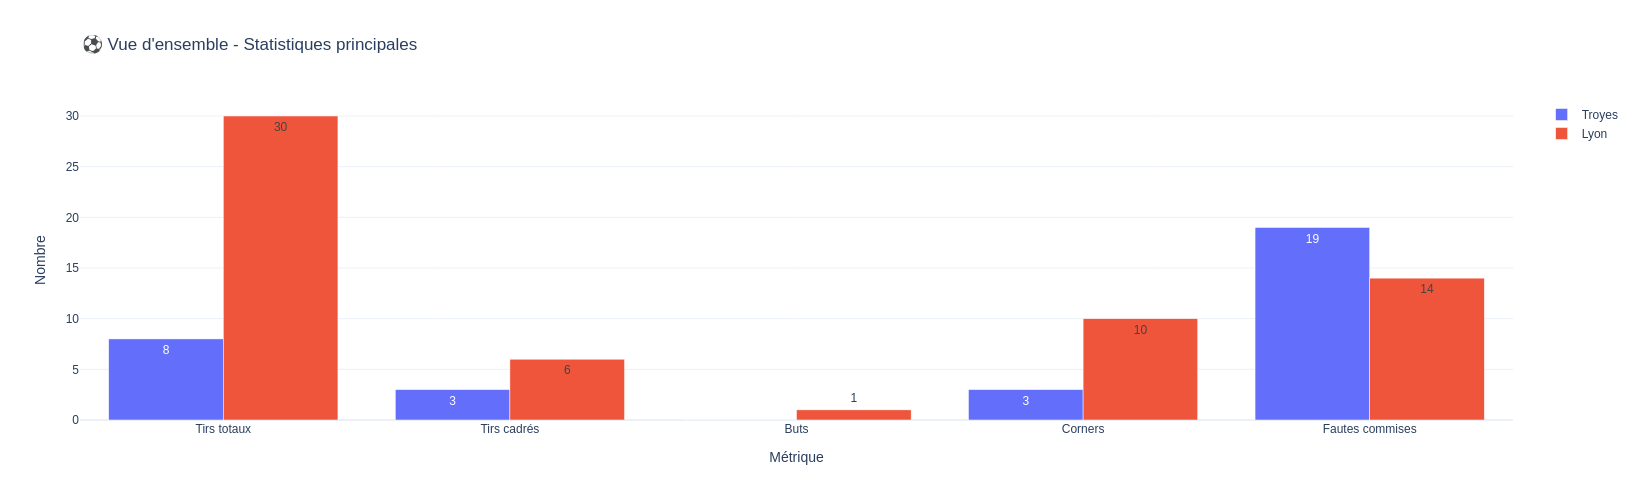

💡 Cliquez sur une équipe dans la légende pour la masquer/afficher


In [17]:
# Graphique 1 : Comparaison des métriques principales

metriques_principales = ['Tirs totaux', 'Tirs cadrés', 'Buts', 'Corners', 'Fautes commises']

fig = go.Figure()

for idx, row in stats_df.iterrows():
    fig.add_trace(go.Bar(
        name=row['Équipe'],
        x=metriques_principales,
        y=[row[m] for m in metriques_principales],
        text=[row[m] for m in metriques_principales],
        textposition='auto',
    ))

fig.update_layout(
    title='⚽ Vue d\'ensemble - Statistiques principales',
    xaxis_title='Métrique',
    yaxis_title='Nombre',
    barmode='group',
    template='plotly_white',
    height=500,
    hovermode='x unified',
    font=dict(size=12)
)

fig.show()

print("💡 Cliquez sur une équipe dans la légende pour la masquer/afficher")

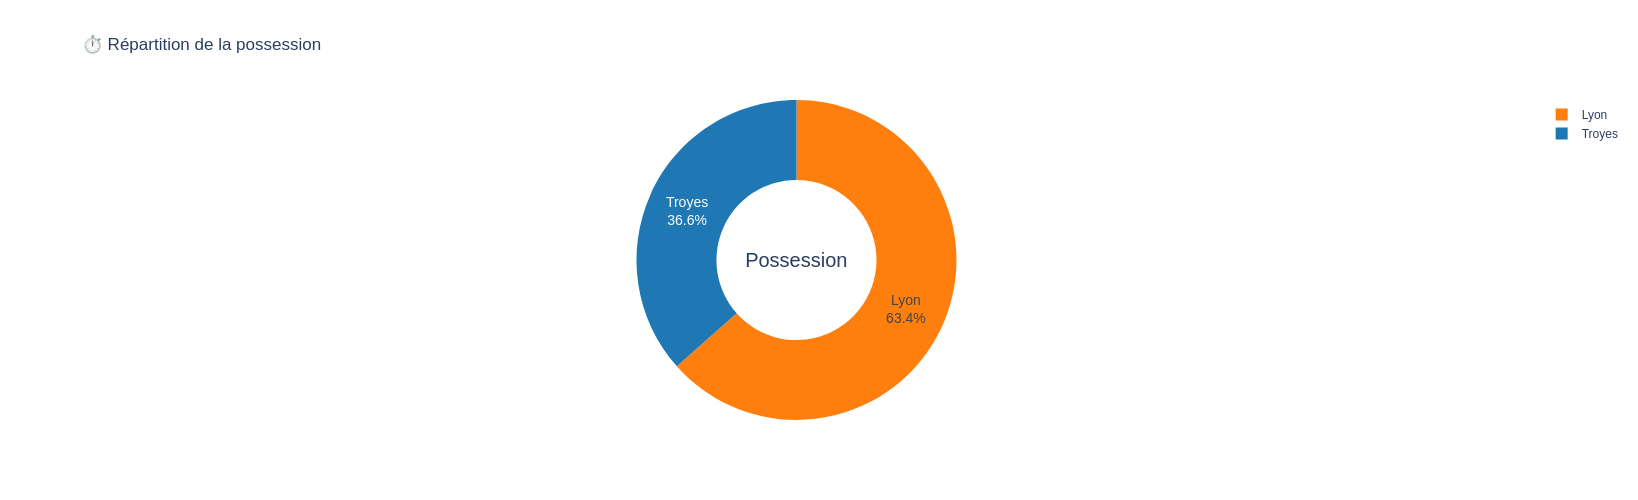

In [18]:
# Graphique 2 : Possession avec donut chart

fig = go.Figure(data=[go.Pie(
    labels=stats_df['Équipe'],
    values=stats_df['Possession (min)'],
    hole=0.5,
    marker_colors=['#1f77b4', '#ff7f0e'],
    textinfo='label+percent',
    textfont_size=14,
    hovertemplate='<b>%{label}</b><br>Temps: %{value:.1f} min<br>Pourcentage: %{percent}<extra></extra>'
)])

fig.update_layout(
    title='⏱️ Répartition de la possession',
    annotations=[dict(text='Possession', x=0.5, y=0.5, font_size=20, showarrow=False)],
    height=500,
    template='plotly_white'
)

fig.show()

## 🎯 Section 4 : Analyse offensive détaillée

### 🎓 Leçon : Efficacité offensive
L'analyse offensive va au-delà des buts. Il faut regarder :
- **xG** : qualité des occasions créées
- **Ratio tirs/buts** : efficacité devant le but
- **Tirs cadrés %** : précision

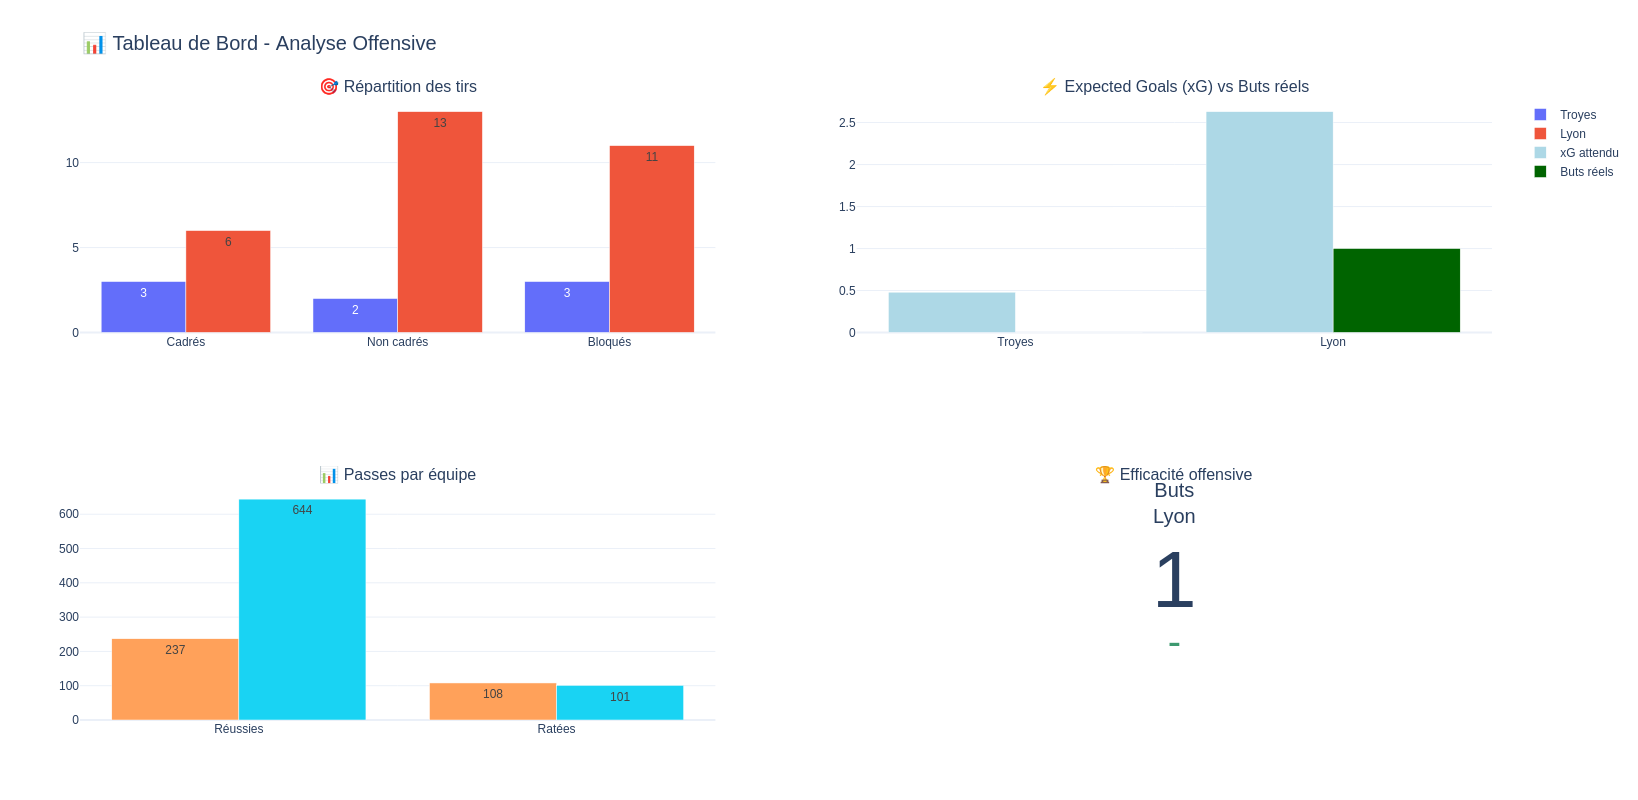


🎓 Interprétation :
• xG > Buts réels = Malchance ou mauvaise finition
• xG < Buts réels = Excellente efficacité ou chance


In [19]:
# Dashboard offensif avec subplots

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        '🎯 Répartition des tirs',
        '⚡ Expected Goals (xG) vs Buts réels',
        '📊 Passes par équipe',
        '🏆 Efficacité offensive'
    ),
    specs=[
        [{'type': 'bar'}, {'type': 'bar'}],
        [{'type': 'bar'}, {'type': 'indicator'}]
    ]
)

# Graphique 1 : Répartition des tirs
for idx, row in stats_df.iterrows():
    fig.add_trace(
        go.Bar(
            name=row['Équipe'],
            x=['Cadrés', 'Non cadrés', 'Bloqués'],
            y=[row['Tirs cadrés'], row['Tirs non cadrés'], row['Tirs bloqués']],
            text=[row['Tirs cadrés'], row['Tirs non cadrés'], row['Tirs bloqués']],
            textposition='auto',
            showlegend=True
        ),
        row=1, col=1
    )

# Graphique 2 : xG vs Buts
x_labels = []
xg_values = []
buts_values = []
for idx, row in stats_df.iterrows():
    x_labels.append(row['Équipe'])
    xg_values.append(row['xG'])
    buts_values.append(row['Buts'])

fig.add_trace(
    go.Bar(name='xG attendu', x=x_labels, y=xg_values, marker_color='lightblue', showlegend=True),
    row=1, col=2
)
fig.add_trace(
    go.Bar(name='Buts réels', x=x_labels, y=buts_values, marker_color='darkgreen', showlegend=True),
    row=1, col=2
)

# Graphique 3 : Passes
for idx, row in stats_df.iterrows():
    fig.add_trace(
        go.Bar(
            name=row['Équipe'],
            x=['Réussies', 'Ratées'],
            y=[row['Passes réussies'], row['Passes totales'] - row['Passes réussies']],
            text=[row['Passes réussies'], row['Passes totales'] - row['Passes réussies']],
            textposition='auto',
            showlegend=False
        ),
        row=2, col=1
    )

# Graphique 4 : Indicateur d'efficacité (équipe dominante)
equipe_dominante = stats_df.loc[stats_df['Buts'].idxmax(), 'Équipe']
buts_max = stats_df['Buts'].max()

fig.add_trace(
    go.Indicator(
        mode="number+delta",
        value=buts_max,
        title={'text': f"Buts<br>{equipe_dominante}"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ),
    row=2, col=2
)

fig.update_layout(
    height=800,
    showlegend=True,
    title_text="📊 Tableau de Bord - Analyse Offensive",
    title_font_size=20,
    template='plotly_white'
)

fig.show()

print("\n🎓 Interprétation :")
print("• xG > Buts réels = Malchance ou mauvaise finition")
print("• xG < Buts réels = Excellente efficacité ou chance")

## 🛡️ Section 5 : Analyse défensive

### 🎓 Leçon : Métriques défensives
Une bonne défense se mesure par :
- **Tacles et interceptions** : récupération du ballon
- **Dégagements** : gestion des situations dangereuses
- **Duels gagnés** : impact physique

In [ ]:
# Graphique comparatif des actions défensives

actions_defensives = ['Tacles', 'Interceptions', 'Dégagements', 'Blocs']

fig = go.Figure()

for idx, row in stats_df.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=[row[action] for action in actions_defensives],
        theta=actions_defensives,
        fill='toself',
        name=row['Équipe']
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max([stats_df[action].max() for action in actions_defensives]) + 5]
        )
    ),
    showlegend=True,
    title='🛡️ Profil défensif - Radar Chart',
    height=600,
    template='plotly_white'
)

fig.show()

print("\n💡 Plus la zone est grande, plus l'équipe est active défensivement")

In [ ]:
# Analyse des duels

fig = go.Figure()

for idx, row in stats_df.iterrows():
    total_duels = row['Duels gagnés'] + row['Duels perdus']
    pourcentage = round(row['Duels gagnés'] / total_duels * 100, 1) if total_duels > 0 else 0
    
    fig.add_trace(go.Bar(
        name='Gagnés',
        x=[row['Équipe']],
        y=[row['Duels gagnés']],
        text=f"{row['Duels gagnés']} ({pourcentage}%)",
        textposition='auto',
        marker_color='green',
        showlegend=(idx == 0)
    ))
    
    fig.add_trace(go.Bar(
        name='Perdus',
        x=[row['Équipe']],
        y=[row['Duels perdus']],
        text=row['Duels perdus'],
        textposition='auto',
        marker_color='red',
        showlegend=(idx == 0)
    ))

fig.update_layout(
    title='💪 Duels : Gagnés vs Perdus',
    xaxis_title='Équipe',
    yaxis_title='Nombre de duels',
    barmode='stack',
    template='plotly_white',
    height=500
)

fig.show()

## 📉 Section 6 : Discipline et comportement

### 🎓 Leçon : Impact de la discipline
Les fautes et cartons affectent :
- Le contrôle du match
- La stratégie (joueurs suspendus)
- L'état d'esprit de l'équipe

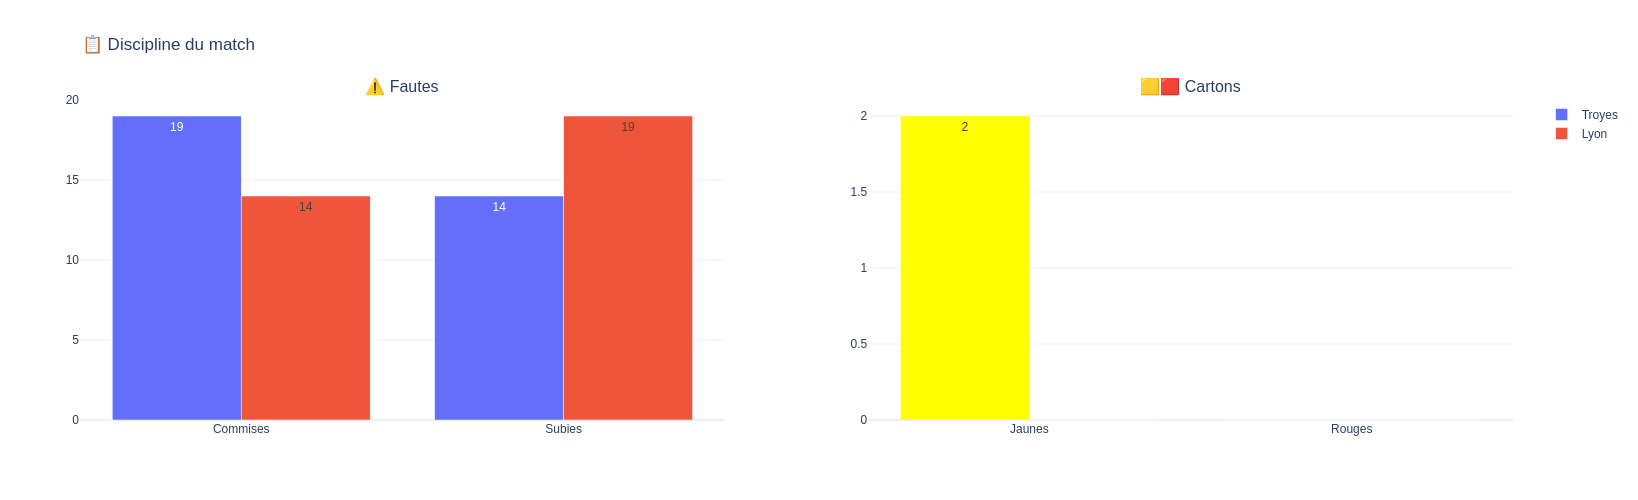

In [20]:
# Discipline et cartons

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('⚠️ Fautes', '🟨🟥 Cartons'),
    specs=[[{'type': 'bar'}, {'type': 'bar'}]]
)

# Graphique 1 : Fautes
for idx, row in stats_df.iterrows():
    fig.add_trace(
        go.Bar(
            name=row['Équipe'],
            x=['Commises', 'Subies'],
            y=[row['Fautes commises'], row['Fautes subies']],
            text=[row['Fautes commises'], row['Fautes subies']],
            textposition='auto',
            showlegend=True
        ),
        row=1, col=1
    )

# Graphique 2 : Cartons
for idx, row in stats_df.iterrows():
    fig.add_trace(
        go.Bar(
            name=row['Équipe'],
            x=['Jaunes', 'Rouges'],
            y=[row['Cartons jaunes'], row['Cartons rouges']],
            text=[row['Cartons jaunes'], row['Cartons rouges']],
            textposition='auto',
            marker_color=['yellow', 'red'][idx],
            showlegend=False
        ),
        row=1, col=2
    )

fig.update_layout(
    height=500,
    barmode='group',
    template='plotly_white',
    title_text='📋 Discipline du match'
)

fig.show()

## ⏱️ Section 7 : Timeline et évolution du match

### 🎓 Leçon : Analyse temporelle
L'évolution minute par minute révèle :
- Les moments d'intensité
- Les changements tactiques
- L'impact des buts

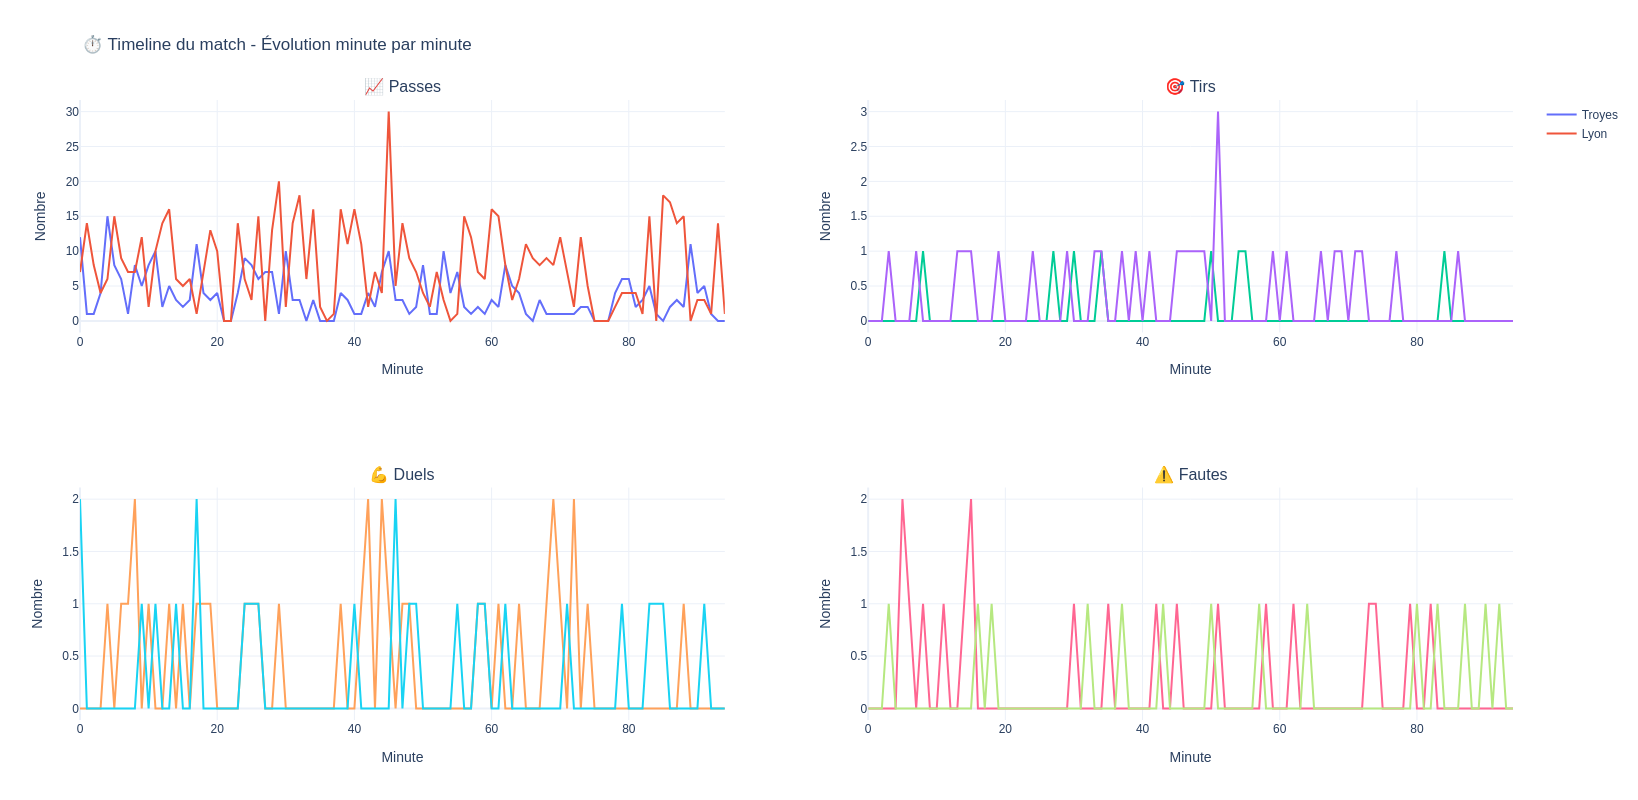


💡 Les pics indiquent les moments d'intensité du match


In [21]:
# Timeline des événements clés

def creer_timeline_detaillee(df):
    """
    Crée une timeline détaillée avec plusieurs types d'événements.
    """
    evenements_cles = ['Pass', 'Shot', 'Duel', 'Foul Committed']
    
    timeline_data = []
    
    for minute in range(0, int(df['minute'].max()) + 1):
        df_minute = df[df['minute'] == minute]
        
        for team in df['team.name'].unique():
            df_team_minute = df_minute[df_minute['team.name'] == team]
            
            for event_type in evenements_cles:
                count = len(df_team_minute[df_team_minute['type.name'] == event_type])
                
                timeline_data.append({
                    'Minute': minute,
                    'Équipe': team,
                    'Type': event_type,
                    'Nombre': count
                })
    
    return pd.DataFrame(timeline_data)

timeline_df = creer_timeline_detaillee(df)

# Créer un graphique pour chaque type d'événement
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('📈 Passes', '🎯 Tirs', '💪 Duels', '⚠️ Fautes'),
)

evenements = ['Pass', 'Shot', 'Duel', 'Foul Committed']
positions = [(1,1), (1,2), (2,1), (2,2)]

for event, pos in zip(evenements, positions):
    df_event = timeline_df[timeline_df['Type'] == event]
    
    for team in df['team.name'].unique():
        df_team = df_event[df_event['Équipe'] == team]
        
        fig.add_trace(
            go.Scatter(
                x=df_team['Minute'],
                y=df_team['Nombre'],
                name=team,
                mode='lines',
                showlegend=(pos == (1,1)),  # Légende uniquement sur le premier
                line=dict(width=2)
            ),
            row=pos[0], col=pos[1]
        )

fig.update_layout(
    height=800,
    title_text='⏱️ Timeline du match - Évolution minute par minute',
    template='plotly_white',
    hovermode='x unified'
)

fig.update_xaxes(title_text='Minute', range=[0, df['minute'].max()])
fig.update_yaxes(title_text='Nombre')

fig.show()

print("\n💡 Les pics indiquent les moments d'intensité du match")

## 📊 Section 8 : Heatmap des actions

### 🎓 Leçon : Analyse spatiale
La position des actions révèle :
- Les zones de pression
- Le style de jeu (possession vs contre-attaque)
- Les faiblesses défensives

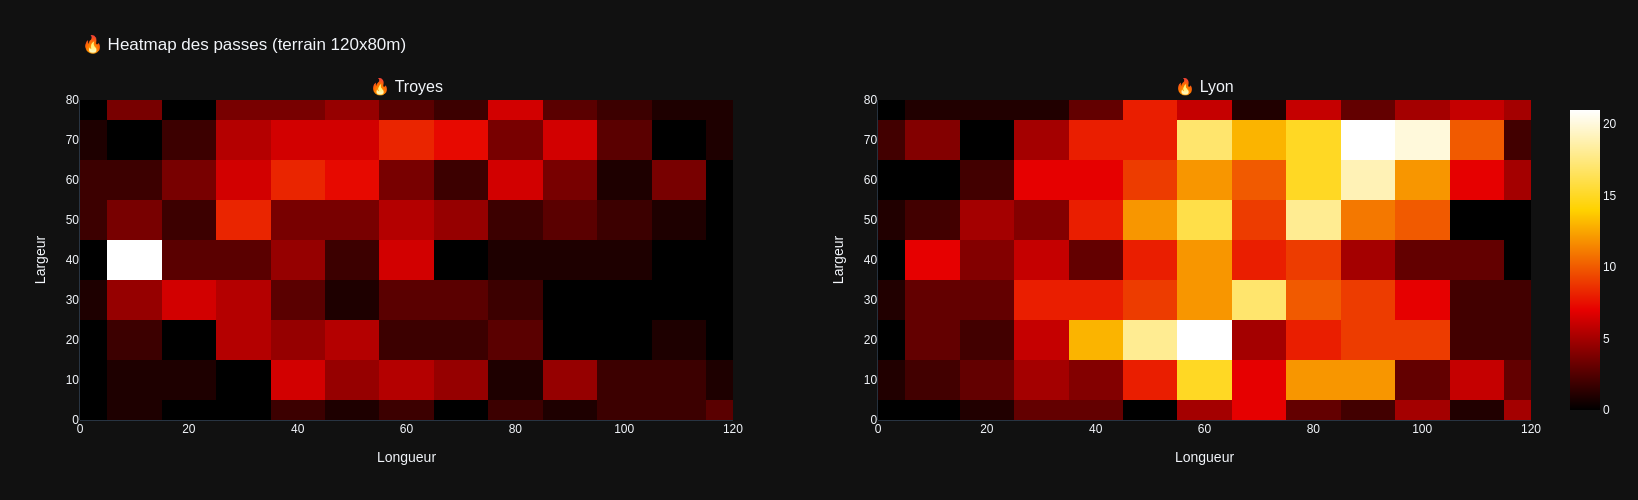


🎓 Interprétation :
• Zones chaudes (rouges/blanches) = forte activité
• Attaque à gauche = passes concentrées à droite


In [22]:
# Heatmap des passes par zone

passes = df[df['type.name'] == 'Pass'].copy()
passes['x'] = passes['location'].apply(lambda loc: loc[0] if isinstance(loc, list) and len(loc) > 0 else None)
passes['y'] = passes['location'].apply(lambda loc: loc[1] if isinstance(loc, list) and len(loc) > 1 else None)
passes_clean = passes.dropna(subset=['x', 'y'])

# Créer une heatmap pour chaque équipe
teams = df['team.name'].unique()

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[f'🔥 {team}' for team in teams],
    specs=[[{'type': 'histogram2d'}, {'type': 'histogram2d'}]]
)

for idx, team in enumerate(teams):
    team_passes = passes_clean[passes_clean['team.name'] == team]
    
    fig.add_trace(
        go.Histogram2d(
            x=team_passes['x'],
            y=team_passes['y'],
            colorscale='Hot',
            nbinsx=15,
            nbinsy=10,
            showscale=(idx == 1)
        ),
        row=1, col=idx+1
    )

fig.update_layout(
    title_text='🔥 Heatmap des passes (terrain 120x80m)',
    height=500,
    template='plotly_dark'
)

fig.update_xaxes(title_text='Longueur', range=[0, 120])
fig.update_yaxes(title_text='Largeur', range=[0, 80])

fig.show()

print("\n🎓 Interprétation :")
print("• Zones chaudes (rouges/blanches) = forte activité")
print("• Attaque à gauche = passes concentrées à droite")

## 📄 Section 9 : Génération du rapport final

### 🎓 Leçon : Rapport professionnel
Un data analyst doit pouvoir générer un rapport complet exportable.

In [23]:
# Créer le rapport final complet

def generer_rapport_html(stats_df, match_id, df):
    """
    Génère un rapport HTML complet avec toutes les visualisations.
    
    Args:
        stats_df: DataFrame avec les statistiques
        match_id: ID du match
        df: DataFrame des événements
    
    Returns:
        str: Chemin du fichier généré
    """
    from datetime import datetime
    
    # Créer le dashboard final avec tous les graphiques
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=(
            '⚽ Score et xG',
            '⏱️ Possession',
            '🎯 Tirs',
            '📊 Passes',
            '🛡️ Actions défensives',
            '⚠️ Discipline'
        ),
        specs=[
            [{'type': 'bar'}, {'type': 'pie'}],
            [{'type': 'bar'}, {'type': 'bar'}],
            [{'type': 'bar'}, {'type': 'bar'}]
        ],
        vertical_spacing=0.12,
        horizontal_spacing=0.15
    )
    
    teams = stats_df['Équipe'].tolist()
    colors = ['#1f77b4', '#ff7f0e']
    
    # 1. Score et xG
    fig.add_trace(go.Bar(name='xG', x=teams, y=stats_df['xG'], marker_color='lightblue'), row=1, col=1)
    fig.add_trace(go.Bar(name='Buts', x=teams, y=stats_df['Buts'], marker_color='darkgreen'), row=1, col=1)
    
    # 2. Possession
    fig.add_trace(go.Pie(labels=teams, values=stats_df['Possession (min)'], hole=0.4), row=1, col=2)
    
    # 3. Tirs
    for idx, row in stats_df.iterrows():
        fig.add_trace(
            go.Bar(name=row['Équipe'], x=['Cadrés', 'Non cadrés'], 
                   y=[row['Tirs cadrés'], row['Tirs non cadrés']], 
                   marker_color=colors[idx], showlegend=False),
            row=2, col=1
        )
    
    # 4. Passes
    for idx, row in stats_df.iterrows():
        fig.add_trace(
            go.Bar(name=row['Équipe'], x=['Réussies'], y=[row['Passes réussies']], 
                   text=f"{row['Taux de passes (%)']}%", textposition='auto',
                   marker_color=colors[idx], showlegend=False),
            row=2, col=2
        )
    
    # 5. Actions défensives
    for idx, row in stats_df.iterrows():
        fig.add_trace(
            go.Bar(name=row['Équipe'], 
                   x=['Tacles', 'Interceptions', 'Dégagements'], 
                   y=[row['Tacles'], row['Interceptions'], row['Dégagements']],
                   marker_color=colors[idx], showlegend=False),
            row=3, col=1
        )
    
    # 6. Discipline
    for idx, row in stats_df.iterrows():
        fig.add_trace(
            go.Bar(name=row['Équipe'], x=['Fautes', 'Cartons jaunes'], 
                   y=[row['Fautes commises'], row['Cartons jaunes']],
                   marker_color=colors[idx], showlegend=False),
            row=3, col=2
        )
    
    # Score final
    score = f"{stats_df.iloc[0]['Équipe']} {stats_df.iloc[0]['Buts']} - {stats_df.iloc[1]['Buts']} {stats_df.iloc[1]['Équipe']}"
    
    fig.update_layout(
        height=1200,
        title_text=f"📊 RAPPORT COMPLET DU MATCH<br><b>{score}</b><br>Match ID: {match_id}",
        title_font_size=24,
        template='plotly_white',
        showlegend=True
    )
    
    # Sauvegarder
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'../outputs/rapport_match_{match_id}_{timestamp}.html'
    
    fig.write_html(filename)
    
    return filename

# Générer le rapport
rapport_path = generer_rapport_html(stats_df, MATCH_ID, df)

print("\n" + "="*80)
print("✅ RAPPORT GÉNÉRÉ AVEC SUCCÈS !")
print("="*80)
print(f"📁 Emplacement : {rapport_path}")
print("\n🎯 Ce que vous pouvez faire avec ce rapport :")
print("  1. Ouvrir dans un navigateur (double-clic)")
print("  2. Envoyer par email aux coachs/analystes")
print("  3. Intégrer dans un site web")
print("  4. Présenter en réunion (plein écran + interactif)")
print("\n💡 Le fichier est complètement autonome (pas besoin d'Internet)")


✅ RAPPORT GÉNÉRÉ AVEC SUCCÈS !
📁 Emplacement : ../outputs/rapport_match_3900493_20260107_092425.html

🎯 Ce que vous pouvez faire avec ce rapport :
  1. Ouvrir dans un navigateur (double-clic)
  2. Envoyer par email aux coachs/analystes
  3. Intégrer dans un site web
  4. Présenter en réunion (plein écran + interactif)

💡 Le fichier est complètement autonome (pas besoin d'Internet)


## 📋 Section 10 : Tableau récapitulatif textuel

Pour un rapport complet, ajoutons un résumé textuel professionnel.

In [24]:
# Générer un résumé textuel

def generer_resume_textuel(stats_df):
    """
    Génère un résumé textuel professionnel du match.
    """
    equipe1 = stats_df.iloc[0]
    equipe2 = stats_df.iloc[1]
    
    print("\n" + "="*80)
    print("📊 RÉSUMÉ STATISTIQUE DU MATCH")
    print("="*80)
    
    # Score
    print(f"\n⚽ SCORE FINAL : {equipe1['Équipe']} {equipe1['Buts']} - {equipe2['Buts']} {equipe2['Équipe']}")
    
    # Possession
    print(f"\n⏱️ POSSESSION :")
    print(f"  • {equipe1['Équipe']}: {equipe1['Possession (%)']}% ({equipe1['Possession (min)']} min)")
    print(f"  • {equipe2['Équipe']}: {equipe2['Possession (%)']}% ({equipe2['Possession (min)']} min)")
    
    # Statistiques offensives
    print(f"\n🎯 STATISTIQUES OFFENSIVES :")
    print(f"\n  {equipe1['Équipe']}:")
    print(f"    - Tirs: {equipe1['Tirs totaux']} (dont {equipe1['Tirs cadrés']} cadrés)")
    print(f"    - Buts: {equipe1['Buts']}")
    print(f"    - xG: {equipe1['xG']}")
    print(f"    - Corners: {equipe1['Corners']}")
    
    print(f"\n  {equipe2['Équipe']}:")
    print(f"    - Tirs: {equipe2['Tirs totaux']} (dont {equipe2['Tirs cadrés']} cadrés)")
    print(f"    - Buts: {equipe2['Buts']}")
    print(f"    - xG: {equipe2['xG']}")
    print(f"    - Corners: {equipe2['Corners']}")
    
    # Passes
    print(f"\n📊 PASSES :")
    print(f"  • {equipe1['Équipe']}: {equipe1['Passes réussies']}/{equipe1['Passes totales']} ({equipe1['Taux de passes (%)']}%)")
    print(f"  • {equipe2['Équipe']}: {equipe2['Passes réussies']}/{equipe2['Passes totales']} ({equipe2['Taux de passes (%)']}%)")
    
    # Défense
    print(f"\n🛡️ STATISTIQUES DÉFENSIVES :")
    print(f"  • {equipe1['Équipe']}: {equipe1['Tacles']} tacles, {equipe1['Interceptions']} interceptions")
    print(f"  • {equipe2['Équipe']}: {equipe2['Tacles']} tacles, {equipe2['Interceptions']} interceptions")
    
    # Discipline
    print(f"\n⚠️ DISCIPLINE :")
    print(f"  • {equipe1['Équipe']}: {equipe1['Fautes commises']} fautes, {equipe1['Cartons jaunes']} carton(s) jaune(s)")
    print(f"  • {equipe2['Équipe']}: {equipe2['Fautes commises']} fautes, {equipe2['Cartons jaunes']} carton(s) jaune(s)")
    
    # Analyse rapide
    print(f"\n💡 ANALYSE RAPIDE :")
    
    # Équipe dominante en possession
    equipe_poss = equipe1['Équipe'] if equipe1['Possession (%)'] > equipe2['Possession (%)'] else equipe2['Équipe']
    print(f"  • Domination possession : {equipe_poss}")
    
    # Équipe la plus offensive
    equipe_off = equipe1['Équipe'] if equipe1['Tirs totaux'] > equipe2['Tirs totaux'] else equipe2['Équipe']
    print(f"  • Équipe la plus offensive : {equipe_off}")
    
    # Efficacité
    eff1 = (equipe1['Buts'] / equipe1['Tirs totaux'] * 100) if equipe1['Tirs totaux'] > 0 else 0
    eff2 = (equipe2['Buts'] / equipe2['Tirs totaux'] * 100) if equipe2['Tirs totaux'] > 0 else 0
    equipe_eff = equipe1['Équipe'] if eff1 > eff2 else equipe2['Équipe']
    print(f"  • Meilleure efficacité offensive : {equipe_eff} ({max(eff1, eff2):.1f}%)")
    
    print("\n" + "="*80)

generer_resume_textuel(stats_df)


📊 RÉSUMÉ STATISTIQUE DU MATCH

⚽ SCORE FINAL : Troyes 0 - 1 Lyon

⏱️ POSSESSION :
  • Troyes: 36.6% (20.4 min)
  • Lyon: 63.4% (35.4 min)

🎯 STATISTIQUES OFFENSIVES :

  Troyes:
    - Tirs: 8 (dont 3 cadrés)
    - Buts: 0
    - xG: 0.48
    - Corners: 3

  Lyon:
    - Tirs: 30 (dont 6 cadrés)
    - Buts: 1
    - xG: 2.63
    - Corners: 10

📊 PASSES :
  • Troyes: 237/345 (68.7%)
  • Lyon: 644/745 (86.4%)

🛡️ STATISTIQUES DÉFENSIVES :
  • Troyes: 36 tacles, 11 interceptions
  • Lyon: 25 tacles, 7 interceptions

⚠️ DISCIPLINE :
  • Troyes: 19 fautes, 2 carton(s) jaune(s)
  • Lyon: 14 fautes, 0 carton(s) jaune(s)

💡 ANALYSE RAPIDE :
  • Domination possession : Lyon
  • Équipe la plus offensive : Lyon
  • Meilleure efficacité offensive : Lyon (3.3%)



## 🎓 Section 11 : Exercices pour vous

### Maintenant à vous de pratiquer !

#### Exercice 1 (Facile) :
Modifiez le code pour analyser un autre match (changez `MATCH_ID`).

#### Exercice 2 (Moyen) :
Ajoutez une nouvelle statistique : le nombre de passes dans le tiers offensif.

#### Exercice 3 (Difficile) :
Créez une fonction qui compare 2 matchs d'une même équipe.

#### Exercice 4 (Expert) :
Analysez tous les 267 matchs et créez un classement des meilleures équipes.

In [ ]:
# Espace pour vos exercices



## 📚 Récapitulatif des compétences apprises

### ✅ Vous avez maintenant appris à :

1. **Charger et traiter des données JSON complexes**
2. **Calculer 30+ statistiques avancées de football**
3. **Créer des visualisations interactives avec Plotly** :
   - Bar charts (groupés, empilés)
   - Pie/Donut charts
   - Radar charts
   - Heatmaps 2D
   - Timeline charts
   - Dashboards multi-graphiques
4. **Analyser l'offensive, la défensive, la discipline**
5. **Générer des rapports HTML professionnels**
6. **Créer des résumés textuels automatisés**

### 🚀 Prochaines étapes :

1. **Analyser plusieurs matchs** pour des tendances de saison
2. **Créer des profils d'équipes** (style de jeu, forces/faiblesses)
3. **Prédictions** : utiliser les stats pour prédire les résultats
4. **Dashboard web** : utiliser Dash pour une interface web complète

---

## 💼 Portfolio pour vos candidatures

Ce notebook démontre des compétences essentielles pour un data analyst :
- ✅ Manipulation de données complexes (JSON, pandas)
- ✅ Création de métriques business
- ✅ Visualisation de données interactive
- ✅ Génération de rapports automatisés
- ✅ Code propre et documenté

**Ajoutez ce projet à votre GitHub et portfolio !**

---

**Bon apprentissage et bonne analyse ! ⚽📊**